##### Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor, RandomForestRegressor

from sklearn import metrics
from scipy.stats import uniform, loguniform

#neural network imports
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
#load model ready data
df = pd.read_csv('model_ready_data.csv')
df = df.set_index('Player')

In [3]:
X = df.drop(columns='Final_PPR_Score')
X = pd.get_dummies(X, columns=['FantPos'], drop_first=True)
y = df['Final_PPR_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [4]:
compare_models = pd.DataFrame()
def add_results(model, title):
    compare_models.loc[title, 'train_accuracy'] = round(model.best_estimator_.score(X_train, y_train), 4)
    compare_models.loc[title, 'test_accuracy'] = round(model.best_estimator_.score(X_test, y_test), 4)
    compare_models.loc[title, 'rmse'] = round(metrics.mean_squared_error(y_test, model.predict(X_test), squared=False), 2)
    compare_models.loc[title, 'best_params'] = str(model.best_params_)

### Linear Regression

In [6]:
lr = LinearRegression()
lr.fit(X_train, y_train)
#add results manually
compare_models.loc['Linear Regression', 'train_accuracy'] = round(lr.score(X_train, y_train), 4)
compare_models.loc['Linear Regression', 'test_accuracy'] = round(lr.score(X_test, y_test), 4)
compare_models.loc['Linear Regression', 'rmse'] = round(metrics.mean_squared_error(y_test, lr.predict(X_test), squared=False), 2)
compare_models.loc['Linear Regression', 'best_params'] = 'N/A'

In [7]:
compare_models

,train_accuracy,test_accuracy,rmse,best_params
Linear Regression,0.4937,0.504,62.34,N/A


**Decent results from a simple linear regression model. 50% of variance in fantasy points are explained by this model. Lets see if we can beat it with some different regressor models**

### Decision Tree Regressor

In [8]:
dt_params = {
    'max_depth': uniform(1, 100),
    'min_samples_split': uniform(0, 1),
    'min_samples_leaf': uniform(0, 1)
}

dt = RandomizedSearchCV(DecisionTreeRegressor(),
                        dt_params,
                        n_iter=50,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        random_state=7)

dt.fit(X_train, y_train)
add_results(dt, 'Decision Tree')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\users\nick\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.38090577        nan 0.37798565 0.326812
 0.326812   0.33257028 0.326812          nan 0.24054805 0.27335601
 0.30971122 0.24495462 0.27335601 0.27136275        nan        nan
 0.31408454        nan        nan        nan        nan        nan
 0.24150504 0.35140643 0.33151894 0.24631083        nan        nan
        nan 0.33007403        nan 0.35215959 0.27285624        nan
 0.27292657        nan        nan        nan        nan        nan
        nan 0.26253088 0.326812          nan        nan 0.38619041
 0.35929536 0.37920883]
  warnings.warn(


In [9]:
compare_models

,train_accuracy,test_accuracy,rmse,best_params
Linear Regression,0.4937,0.5040,62.34,N/A
Decision Tree,0.4419,0.4387,66.31,"{'max_depth': 17.471665877901287, 'min_samples..."


**Decision Tree Regressor was worse than our linear regression model in every metric. It is also slightly overfit**

### Gradient Boost Regressor

In [10]:
gb_params = {
    'learning_rate': uniform(.0001, 50),
    'n_estimators': [1, 10, 100, 1000],
    'subsample': uniform(.1, 1),
    'min_samples_split': uniform(0, .5),
    'min_samples_leaf': uniform(0, .5),
    'max_depth': uniform(2, 100),
    'max_features': ['auto', 'sqrt', 'log2', uniform(0, 1)]
}

gb = RandomizedSearchCV(GradientBoostingRegressor(),
                        gb_params,
                        n_iter=200,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        random_state=7)

gb.fit(X_train, y_train)
add_results(gb, 'Gradient Boost')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


c:\users\nick\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [             nan -2.02623334e+002              nan              nan
              nan -1.02498103e+015              nan              nan
              nan              nan              nan              nan
              nan -1.12606992e-001 -2.83020241e-001              nan
              nan              nan -5.35288572e-003              nan
              nan -1.55559728e+277 -1.87319879e+030 -3.29774892e+029
              nan  3.51308636e-001 -1.18637265e+025              nan
              nan -6.86937975e+029 -4.39773613e-001              nan
 -4.20272693e+202              nan              nan              nan
 -6.79159645e+000              nan              nan             -inf
             -inf -1.06685054e+021              nan -3.74422230e+025
 -4.39431540e+001              nan              nan              nan
 

In [11]:
compare_models

,train_accuracy,test_accuracy,rmse,best_params
Linear Regression,0.4937,0.5040,62.34,N/A
Decision Tree,0.4419,0.4387,66.31,"{'max_depth': 17.471665877901287, 'min_samples..."
Gradient Boost,0.4250,0.4251,67.11,"{'learning_rate': 0.440055535013975, 'max_dept..."


**Gradient Boost is even worse. I'm going the wrong way with these models. Let's try random forest**

### Random Forest

In [12]:
rf_params = {
    'max_depth': uniform(1, 100),
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': uniform(0, 1),
    'min_samples_leaf': uniform(0, 1),
    'n_estimators': [1, 10, 100, 1000]
}

rf = RandomizedSearchCV(RandomForestRegressor(),
                        rf_params,
                        n_iter=50,
                        cv=5,
                        n_jobs=-1,
                        verbose=True,
                        random_state=7)

rf.fit(X_train, y_train)
add_results(rf, 'Random Forest')

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\users\nick\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-0.00485554  0.30846325         nan         nan         nan         nan
 -0.00492874  0.27404662 -0.01156059  0.15629256  0.16561464 -0.00420486
  0.20604668  0.25426931         nan         nan         nan         nan
 -0.00401122         nan  0.20811523 -0.00493805         nan -0.00471584
         nan -0.00503593 -0.00671458 -0.00496082 -0.0051414          nan
 -0.00390697  0.31950024  0.16313237         nan  0.35730533         nan
         nan         nan         nan -0.0038319  -0.00687167 -0.0050054
 -0.00573988  0.23427293         nan         nan -0.00525201 -0.00692729
 -0.00480808  0.41265136]
  warnings.warn(


In [13]:
compare_models

,train_accuracy,test_accuracy,rmse,best_params
Linear Regression,0.4937,0.5040,62.34,N/A
Decision Tree,0.4419,0.4387,66.31,"{'max_depth': 17.471665877901287, 'min_samples..."
Gradient Boost,0.4250,0.4251,67.11,"{'learning_rate': 0.440055535013975, 'max_dept..."
Random Forest,0.4819,0.4868,63.41,"{'max_depth': 93.26031530779568, 'max_features..."


**Random forest is the second best model so far but these are all still not great. Lets move to building a neural network to really see if we can get over 50% and lower than 62.34 RMSE**

### Neural Network

In [14]:
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [15]:
def model_func(layer_one_neurons=8, layer_two_neurons=8, dropout=0.2):
    np.random.seed(7)
    
    nn_model = Sequential()
    nn_model.add(Dense(26, input_shape=(26,), activation='relu'))
    nn_model.add(Dropout(dropout))
    nn_model.add(Dense(layer_one_neurons, activation='relu'))
    nn_model.add(Dropout(dropout))
    nn_model.add(Dropout(dropout))
    nn_model.add(Dense(layer_two_neurons, activation='relu'))
    nn_model.add(Dropout(dropout))
    nn_model.add(Dense(1))

    nn_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

    return nn_model

nn = KerasRegressor(build_fn=model_func, batch_size=16, epochs=100, verbose=0)

params = {'layer_one_neurons': [8, 16, 32, 64, 200],
         'layer_two_neurons': [8, 16, 32, 64, 200],
         'batch_size': [1, 2, 4, 8, 16, 32],
         'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
         'epochs':[25, 50, 100, 200]}

grid = RandomizedSearchCV(nn, params, n_iter=100, cv=3)

In [16]:
%time
grid.fit(Xs_train, y_train)

Wall time: 0 ns


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000166B0934610>,
                   n_iter=100,
                   param_distributions={'batch_size': [1, 2, 4, 8, 16, 32],
                                        'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
                                        'epochs': [25, 50, 100, 200],
                                        'layer_one_neurons': [8, 16, 32, 64,
                                                              200],
                                        'layer_two_neurons': [8, 16, 32, 64,
                                                              200]})

In [33]:
grid.best_params_

{'layer_two_neurons': 64,
 'layer_one_neurons': 200,
 'epochs': 100,
 'dropout': 0.3,
 'batch_size': 8}

In [31]:
#predict with best model
np.random.seed(7)
best_params_model = Sequential()
best_params_model.add(Dense(26, input_shape=(26,), activation='relu'))
best_params_model.add(Dropout(0.3))
best_params_model.add(Dense(64, activation='relu'))
best_params_model.add(Dropout(0.3))
best_params_model.add(Dropout(0.3))
best_params_model.add(Dense(200, activation='relu'))
best_params_model.add(Dropout(0.3))
best_params_model.add(Dense(1))

best_params_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
early_stop = EarlyStopping(monitor='val_mse', min_delta=0, patience=10, verbose=1)
history = best_params_model.fit(Xs_train, y_train, validation_data=(Xs_test, y_test), epochs=100, batch_size=8, verbose=1, callbacks=[early_stop])

preds = best_params_model.predict(Xs_test)

Epoch 1/100
129/129 [==============================] - 0s 934us/step - loss: 17153.9863 - mse: 17153.9863 - val_loss: 4442.8442 - val_mse: 4442.8442
Epoch 2/100
129/129 [==============================] - 0s 702us/step - loss: 6522.6514 - mse: 6522.6514 - val_loss: 4215.9106 - val_mse: 4215.9106
Epoch 3/100
129/129 [==============================] - 0s 581us/step - loss: 6303.5283 - mse: 6303.5283 - val_loss: 4025.0925 - val_mse: 4025.0925
Epoch 4/100
129/129 [==============================] - 0s 574us/step - loss: 5810.0796 - mse: 5810.0796 - val_loss: 4179.7886 - val_mse: 4179.7886
Epoch 5/100
129/129 [==============================] - 0s 584us/step - loss: 6342.6479 - mse: 6342.6479 - val_loss: 4215.3613 - val_mse: 4215.3613
Epoch 6/100
129/129 [==============================] - 0s 581us/step - loss: 6004.2222 - mse: 6004.2222 - val_loss: 3956.9365 - val_mse: 3956.9365
Epoch 7/100
129/129 [==============================] - 0s 586us/step - loss: 5989.0049 - mse: 5989.0049 - val_loss: 

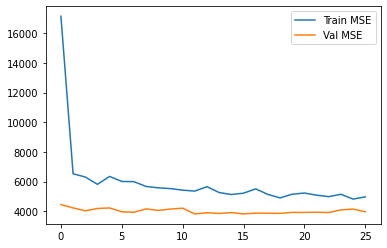

In [38]:
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend();

In [35]:
np.sqrt(min(history.history['val_mse']))

61.747483422277014

**The nerual network gave us our best RMSE of 61.74. However,it's still not that much better than linear regression.**

Lets try and see our RMSEs by position

In [36]:
original_df = pd.read_csv('gathered_data.csv')
positional_preds_df = original_df[['Player', 'FantPos']]
preds_df = pd.DataFrame(y_test).merge(positional_preds_df, on='Player', how='left')
positional_preds_df = pd.DataFrame({'Player': preds_df['Player'],
                                    'Position': preds_df['FantPos'],
                                    'Actual_Points':preds_df['Final_PPR_Score'],
                                    'Predicted_Points': [x[0] for x in preds]})

In [37]:
for pos in ['QB', 'RB', 'WR', 'TE']:
    pos_df = positional_preds_df[positional_preds_df['Position'] == pos]
    pos_rmse = metrics.mean_squared_error(pos_df['Actual_Points'], pos_df['Predicted_Points'], squared=False)
    print(f'{pos} RMSE: {pos_rmse}')

QB RMSE: 75.8686737956309
RB RMSE: 61.07556562314362
WR RMSE: 62.77588566115266
TE RMSE: 55.35261748944908


**Interesting that our QB RMSE was far higher than any other position. I think thats because QB stats are sort of in a world of their own, they dont relate with any of the other positions wheras RBs, WRs, and TEs all have similar stats. I think if I was doing this over I would model QBs seperately**